In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
from scipy.stats import hypergeom
from matplotlib import rcParams
from collections import defaultdict
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['axes.formatter.useoffset'] = False


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def formatAxes(ax,text_size=10,xlim=None,xlabel=None,xticks=None,xticklabels=None,ylim=None,yticks=None,ylabel=None,yticklabels=None):
    """ to tweak the plotting of the axes as well as the fontsize """
    for loc,spine in list(ax.spines.items()):
        if loc == 'left': # settings for the y-axis
            if yticklabels and not yticks:
                sys.stderr.write("Need to provide a list wiht both y-labels and y-ticks!")
            if yticks:
                ax.yaxis.set_ticks_position('left')
                ax.yaxis.set_tick_params(direction='out')
                spine.set_visible(True)
                spine.set_position(("outward",1))
                spine.set_smart_bounds(True)
                ax.set_yticks(yticks)
                if ylim:
                    ax.set_ylim(ylim)
                if yticklabels:
                    ax.set_yticklabels(yticklabels,fontsize=text_size)
            else:
                spine.set_visible(False)
                ax.set_yticklabels([])
                ax.tick_params(axis='y',which='both',length=0)
                
            if ylabel:
                ax.set_ylabel(ylabel,fontsize=text_size,rotation=0,labelpad=160)
                ax.get_yaxis().set_label_coords(-0.1,0.5)
        elif loc == 'bottom': # settings for x-axis
            if xticks:
                spine.set_position('zero')
                spine.set_visible(False)
                spine.set_smart_bounds(False)
                ax.set_xticks(xticks)
                ax.tick_params(axis='x',which='both',length=0)
                if xlim:
                    ax.set_xlim(xlim)
                if xticklabels:
                    ax.set_xticklabels(xticklabels,fontsize=text_size)
            else:
                spine.set_visible(False)
                ax.set_xticklabels([])
                ax.tick_params(axis='x',which='both',length=0)
                
            if xlabel:
                ax.tick_params(axis='x',which='both',length=0)
                ax.set_xlabel(xlabel,fontsize=text_size+2)
                ax.xaxis.labelpad = 10
        else:
            spine.set_visible(False)
    ax.patch.set_visible(False)

In [3]:
## Loading the big dataframe
alldata = pd.read_csv('../../../big_dataframe_Xist_diffBUM_HMM_scaled_dc_regions_removed_deltaSHAPE_corrected.txt',sep="\t",header=0,index_col=0)

In [4]:
alldata.head()

,nucleotide_number,nucleotide_identity,DeltaSHAPE_ex_vivo,DeltaSHAPE_in_cell,average_deltaSHAPE,CELF1,FUS,HuR,PTBP1,RBFOX2,TARDBP,diffBUMHMM_in_cell,diffBUMHMM_ex_vivo,dStruct_DDR,DeltaSHAPE_in_vivo
0,1,C,0,0,0.0,0,0,0,0,0,0,1.693237e-14,1.790644e-20,0,1.0
1,2,G,0,0,0.0,0,0,0,0,0,0,6.789051e-03,6.823904e-03,0,1.0
2,3,G,0,0,0.0,0,0,0,0,0,0,9.031615e-03,9.110841e-03,0,1.0
3,4,C,0,0,0.0,0,0,0,0,0,0,6.793530e-03,6.927069e-03,0,1.0
4,5,T,0,0,0.0,0,0,0,0,0,0,1.128597e-08,5.186918e-06,0,1.0


### Count number of DRNs in diffBUM_HMM data:

In [5]:
threshold = 0.95

num_diff_nucl_ex_vivo = len(alldata[alldata.diffBUMHMM_ex_vivo > threshold].index)
num_diff_nucl_in_cell = len(alldata[alldata.diffBUMHMM_in_cell > threshold].index)

print("ex_vivo\t",num_diff_nucl_ex_vivo)
print("in_vivo\t",num_diff_nucl_in_cell)

ex_vivo	 1739
in_vivo	 188


### Count number of DRNs in deltaSHAPE data:

In [6]:
threshold = 0.95

num_diff_nucl_ex_vivo_deltaSHAPE = len(alldata[alldata.DeltaSHAPE_ex_vivo > 0].index)
num_diff_nucl_in_cell_deltaSHAPE = len(alldata[alldata.DeltaSHAPE_in_cell > 0].index)
        
print("ex_vivo\t",num_diff_nucl_ex_vivo_deltaSHAPE)
print("in_vivo\t",num_diff_nucl_in_cell_deltaSHAPE)

ex_vivo	 866
in_vivo	 683


### How many binding sites for each protein were found that overlapped with modified nucleotides in the ex vivo data?

In [7]:
morereactive_ex_vivo = alldata[alldata.diffBUMHMM_ex_vivo > threshold]
morereactive_in_cell = alldata[alldata.diffBUMHMM_in_cell > threshold]
morereactive_ex_vivo_deltaSHAPE = alldata[alldata.average_deltaSHAPE > 0]
morereactive_in_cell_deltaSHAPE = alldata[alldata.average_deltaSHAPE < 0]
proteins = alldata.columns[5:11]

In [8]:
dict_total_binding_sites_differential_exvivo = {}
dict_total_binding_sites_differential_incell = {}
dict_total_binding_sites_differential_exvivo_deltaSHAPE = {}
dict_total_binding_sites_differential_incell_deltaSHAPE = {}

for protein in proteins:
    #print("%s\ttotal_count:\t%s" % (protein,morereactive_ex_vivo[protein].sum()))
    dict_total_binding_sites_differential_exvivo[protein]=morereactive_ex_vivo[protein].sum()
    dict_total_binding_sites_differential_exvivo_deltaSHAPE[protein]=morereactive_ex_vivo_deltaSHAPE[protein].sum()

    
for protein in proteins:
    #print("%s\ttotal_count:\t%s" % (protein,morereactive_ex_vivo[protein].sum()))
    dict_total_binding_sites_differential_incell[protein]=morereactive_in_cell[protein].sum()
    dict_total_binding_sites_differential_incell_deltaSHAPE[protein]=morereactive_in_cell_deltaSHAPE[protein].sum()
    
print(dict_total_binding_sites_differential_exvivo)
print(dict_total_binding_sites_differential_incell)
print(dict_total_binding_sites_differential_exvivo_deltaSHAPE)
print(dict_total_binding_sites_differential_incell_deltaSHAPE)

{'CELF1': 60, 'FUS': 375, 'HuR': 96, 'PTBP1': 53, 'RBFOX2': 2, 'TARDBP': 58}
{'CELF1': 11, 'FUS': 33, 'HuR': 17, 'PTBP1': 10, 'RBFOX2': 2, 'TARDBP': 2}
{'CELF1': 104, 'FUS': 162, 'HuR': 171, 'PTBP1': 95, 'RBFOX2': 3, 'TARDBP': 8}
{'CELF1': 24, 'FUS': 192, 'HuR': 34, 'PTBP1': 21, 'RBFOX2': 0, 'TARDBP': 16}


In [9]:
##IN CELL

In [10]:
morereactive_in_cell = alldata[alldata.diffBUMHMM_in_cell > threshold]
proteins = alldata.columns[5:11]

In [11]:
for protein in proteins:
    print("%s\ttotal_count:\t%s" % (protein,morereactive_in_cell[protein].sum()))

CELF1	total_count:	11
FUS	total_count:	33
HuR	total_count:	17
PTBP1	total_count:	10
RBFOX2	total_count:	2
TARDBP	total_count:	2


In [12]:
#SETTING NUCLEOTIDES TO ZERO IF FALLING IN REGIONS NOT USED BY DIFFBUM HMM
'''
proteins = alldata.columns[5:11]

for index, row in alldata.iterrows():
    if row.values[0]>=1 and row.values[0]<=78 or row.values[0]>=2451 and row.values[0]<=2599 or row.values[0]>=2500 and row.values[0]<=4500 or row.values[0]>=17801 and row.values[0]<=17918:
        for protein in proteins:
            row[protein]=0

''' 
       
#COUNTING UP TOTAL NUMBER OF PROTEIN BINDING SITES, EXCLUDING REGIONS NOT USED BY DIFFBUMHM

dict_total_binding_sites={}
for protein in proteins:
    dict_total_binding_sites[protein]=alldata[protein].sum()
    
print(dict_total_binding_sites)

{'CELF1': 781, 'FUS': 3587, 'HuR': 1137, 'PTBP1': 582, 'RBFOX2': 63, 'TARDBP': 517}


In [13]:
print(dict_total_binding_sites['CELF1'])

781


### diffBUM_HMM individual sites:

         ex vivo   in vivo
CELF1   2.146493       NaN
FUS     2.223230       NaN
HuR     1.856584  1.442927
PTBP1        NaN  1.362441
RBFOX2  1.441929       NaN
TARDBP  1.537798       NaN


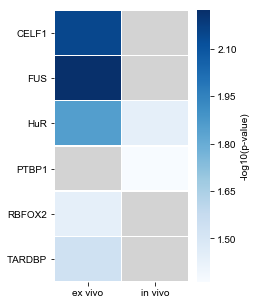

In [14]:
'''
Written by Sander
“M" would be total number of Xist nucleotides.
“n” would in your case be total number of nucleotides that are part of an RNA-binding site (i.e. FUS, etc).
“x” would be the total number of differentially modified nucleotides in ex vivo that overlap with the RNA-binding site.
“N” would be the total number of differentially modified nucleotides in ex vivo.
'''
diffbumhmmpvalues = defaultdict(lambda: defaultdict(float))

#Length Xist
M = 17918

for protein in proteins:
    n = int(dict_total_binding_sites[protein])
    
    #EXVIVO
    N = num_diff_nucl_ex_vivo
    x = dict_total_binding_sites_differential_exvivo[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    diffbumhmmpvalues["ex vivo"][protein] = p_value
    
    #INCELL
    N = num_diff_nucl_in_cell
    x = dict_total_binding_sites_differential_incell[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    diffbumhmmpvalues["in vivo"][protein] = p_value

output = pd.DataFrame.from_dict(diffbumhmmpvalues,orient='columns')
output = output.mask(output > 0.05)
output = output.apply(np.log10)*-1
print(output)

fig,ax = plt.subplots(figsize=[3,5])
mask = output.isnull()
ax = sns.heatmap(output,cmap="Blues",linewidths=.5,mask=mask,cbar_kws={'label':'-log10(p-value)'})
ax.set_facecolor("lightgrey")
ax.set_yticklabels(ax.get_yticklabels(),rotation=None,horizontalalignment='right')

fig.savefig("difBUM_HMM_protein_enrichment_pvalues.pdf",dpi=400)

### deltaSHAPE individual sites:

          ex vivo   in vivo
CELF1    3.766742  5.775663
FUS     36.530294       inf
HuR      8.990349  7.724744
PTBP1    6.903224  6.184777
RBFOX2        NaN       NaN
TARDBP  13.842985  4.085594


[Text(0, 0.5, 'CELF1'),
 Text(0, 1.5, 'FUS'),
 Text(0, 2.5, 'HuR'),
 Text(0, 3.5, 'PTBP1'),
 Text(0, 4.5, 'RBFOX2'),
 Text(0, 5.5, 'TARDBP')]

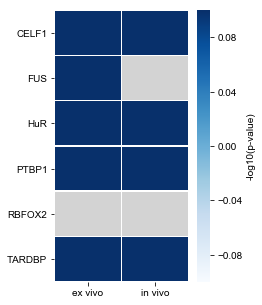

In [18]:
'''
Written by Sander
“M" would be total number of Xist nucleotides.
“n” would in your case be total number of nucleotides that are part of an RNA-binding site (i.e. FUS, etc).
“x” would be the total number of differentially modified nucleotides in ex vivo that overlap with the RNA-binding site.
“N” would be the total number of differentially modified nucleotides in ex vivo.
'''
deltashapepvalues = defaultdict(lambda: defaultdict(float))

#Length Xist
M = 17918

for protein in proteins:
    n = int(dict_total_binding_sites[protein])
    
    #EXVIVO
    N = num_diff_nucl_ex_vivo
    x = dict_total_binding_sites_differential_exvivo_deltaSHAPE[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    deltashapepvalues["ex vivo"][protein] = p_value

    #INCELL
    N = num_diff_nucl_in_cell
    x = dict_total_binding_sites_differential_incell_deltaSHAPE[protein]
    hpd = hypergeom(M, n, N)
    p_value = hpd.pmf(x)
    deltashapepvalues["in vivo"][protein] = p_value

output = pd.DataFrame.from_dict(deltashapepvalues,orient='columns')
output = output.mask(output > 0.05)
output = output.apply(np.log10)*-1
print(output)

fig,ax = plt.subplots(figsize=[3,5])
mask = output.isnull()
ax = sns.heatmap(output,cmap="Blues",linewidths=.5,mask=mask,cbar_kws={'label':'-log10(p-value)'})
ax.set_facecolor("lightgrey")
ax.set_yticklabels(ax.get_yticklabels(),rotation=None,horizontalalignment='right')

### All sites diffBUM_HMM

In [16]:
totals_binding_sites = 0
totals_binding_sites_differential_exvivo = 0
totals_binding_sites_differential_incell = 0

for protein in proteins:
    totals_binding_sites += int(dict_total_binding_sites[protein])
    totals_binding_sites_differential_exvivo += dict_total_binding_sites_differential_exvivo[protein]
    totals_binding_sites_differential_incell += dict_total_binding_sites_differential_incell[protein]
    
M = 17918
#EXVIVO
N = num_diff_nucl_ex_vivo
n= totals_binding_sites
x =totals_binding_sites_differential_exvivo

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('ex_vivo ' +str(p_value))

#INCELL
N = num_diff_nucl_in_cell
n= totals_binding_sites
x=totals_binding_sites_differential_incell 

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('in_cell ' +str(p_value))

ex_vivo 0.020579798541598422
in_cell 0.04461663691643808


### All sites deltaSHAPE

In [17]:
totals_binding_sites = 0
totals_binding_sites_differential_exvivo = 0
totals_binding_sites_differential_incell = 0

for protein in proteins:
    totals_binding_sites += int(dict_total_binding_sites[protein])
    totals_binding_sites_differential_exvivo += dict_total_binding_sites_differential_exvivo_deltaSHAPE[protein]
    totals_binding_sites_differential_incell += dict_total_binding_sites_differential_incell_deltaSHAPE[protein]
    
M = 17918
#EXVIVO
N = num_diff_nucl_ex_vivo_deltaSHAPE
n = totals_binding_sites
x = totals_binding_sites_differential_exvivo

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('ex_vivo ' +str(p_value))

#INCELL
N = num_diff_nucl_in_cell_deltaSHAPE
n = totals_binding_sites
x = totals_binding_sites_differential_incell 

hpd = hypergeom(M, n, N)
p_value = hpd.pmf(x)
print('in_cell ' +str(p_value))

ex_vivo 6.2218155652274196e-55
in_cell 0.000985572801560568
